# 2016 President of the United States Primary Election Results
![flag](http://www.brandsoftheworld.com/sites/default/files/styles/logo-thumbnail/public/0003/8643/brand.gif?itok=SW-ahLkN) 
### Project Overview
- The objective of this work is to leverage machine-learning techniques to predict whom voters are most likely to elect as the party’s nominee in 2016 Primary Election based on a series of demographics. A large database containing election results for both Democrat and Republican candidates from 28 primary state counties was queried and merged with demographic facts obtained from the United States Census Bureau for corresponding counties. This work examines patterns and trends in how voters cast their ballot given a larger feature space of county demographics spread throughout the United States. In some cases, some states are called with no actual votes tallied. This can come from models, similar to this work, where county-by-county demographics are analyzed for voting trends. The objective is to generate a predictive model and fine tune it such that the algorithm learns from a series of training examples and generalizes to an out of sample testing set that correctly classifies a discrete label, the candidate winner of the respected primary county. 


- In today’s politics, candidates rely heavily on polls to make campaign decisions, but what if before hand we could identify which candidate is more likely to win a given county based on county statistics such as ethnicity, education, income, gender, retail sales, number of business, etc. The demographic dataset at hand does not tell who has voted, but rather who lives in the respected counties. Linking together the county facts with the winner of the 2016 primary elections of each county becomes a supervised learning problem as the features and the labels are the demographics and candidates (winners), respectively. Several learning algorithms will be explored and examined as to which classifier performs the best when predicting the class label. For example, a decision tree is constructed which goes through a series binary splitting criteria from the root node to the parent/child nodes and ultimately at the terminal leaf, attributes that were highly influential in the success of the respected candidate can be identified. Perhaps this information could provide valuable insight into how Democrats or Republicans campaigns should adjust their strategies moving forward in the remaining primaries. For instance, a candidate who is not predicted to perform well in heavily populated counties could increase spending on advertisement in order to enhance their support. As we navigate through the remaining primary states, any edge a candidate can have to boost their support base could potentially be the difference in accumulating the required number of delegates to become the party’s nominee. In this work, analysis in voter trends for both parties will be discussed in detail, however the machine-learning algorithm only considers the Republican Party and the current nominees still present in the 2016 race for the White House. Those candidates will each be a class label and are as follows: Businessman Donald Trump, Senator Ted Cruz (R-Texas), and Governor John Kasich (R-Ohio). The same workflow outlined in this report could also be implemented for the Democratic Party. 

### Dataset
- The data utilized in the work is obtained from [`kaggle`](https://www.kaggle.com/benhamner/2016-us-election). Additional information from the primary results for each primary state can be found at [`CNN`](http://www.cnn.com/election/primaries/counties/ia/Dem) and the country facts is gathered from the [`United States Census Bureau`](http://www.census.gov/quickfacts/404.php).

### Python Libraries 

In [3]:
import sys
import pandas as pd
#pd.set_option('display.max_rows', 1300)
import numpy as np
import matplotlib.pyplot as pl
import networkx as nx
import pygraphviz
import seaborn as sns
import sqlite3
import time
import pydot
import os
import time
from StringIO import StringIO
from io import BytesIO
from IPython.display import Image
%matplotlib inline

import warnings #ignore warnings
warnings.filterwarnings('ignore')

### Import from Sci-Kit Learn

In [4]:
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.metrics import f1_score, accuracy_score
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn import tree
from sklearn.externals.six import StringIO   
from sklearn.tree import export_graphviz
from sklearn.feature_extraction import DictVectorizer

### Database Queries

- The 2016 Primary Election for POTUS dataset is obtained from Kaggle, which includes a large database of election results (CNN) and demographics (U.S. Census Bureau) contaning two tables: `county_facts` and `primary_results`. The ‘primary_results’ table in the ‘database.sqlite’ file. To query the database and create additional tables, a relational database management system SQLite is utilized. Calling the `sqlite3` function from the python standard library provides the interface for accessing the SQLite database. In order to use the structured query language in the Ipython notebook, SQLite magic command is required (pip install ipython-sql). Additionally, ‘pandas’ is also used several times in the script to read a SQL command and stores the query into a DataFrame. 

In [5]:
%sqlite_execute #ipython magic

# Connect/Load Database
%load_ext sql
%sql sqlite:///database.sqlite 
try:    
    db = sqlite3.connect('database.sqlite')
    c = db.cursor()
    print "Successfully connected to the database"
except IntegrityError:
    print"Did not successfully connect to database"

ERROR: Line magic function `%sqlite_execute` not found.


Successfully connected to the database


- Create tables and output queries in .csv format using the following SQL queries:

In [ ]:
%sql SELECT * FROM primary_results

%sql ALTER TABLE primary_results ADD COLUMN county_state TEXT;
%sql UPDATE primary_results SET county_state = (county || "_" || state_abbreviation);
%sql UPDATE primary_results SET candidate = Replace(candidate,' ','_');

'''Create Republican Table:'''
%sql CREATE TABLE Republicans AS SELECT * FROM primary_results;
%sql DELETE FROM Republicans WHERE(party ='Democrat') 

'''Create Democrat Table:'''
%sql CREATE TABLE Democrats AS SELECT * FROM primary_results;
%sql DELETE FROM Democrats WHERE(party ='Republican') 

'''Update County Facts Table:'''
%sql UPDATE county_facts SET state_abbreviation = NULL WHERE state_abbreviation = '';
%sql DELETE FROM county_facts WHERE state_abbreviation IS NULL;
%sql ALTER TABLE county_facts ADD COLUMN county_state TEXT;
%sql UPDATE county_facts SET area_name = SUBSTR(area_name,1, LENGTH(area_name)-7);
%sql UPDATE county_facts SET county_state = (area_name || "_" || state_abbreviation);
%sql UPDATE county_facts SET county_state = REPLACE(county_state,'"','');

#Output County_Facts_Description as CSV file (.mode csv)
#%sql .output county_facts_dict.csv # command in terminal

In [ ]:
'''SQL TABLES FOR TO GROUP WINNER OF EACH COUNTY:'''

#Identify the Republican winner in each county:
%sql SELECT state, state_abbreviation, county, fips, party, candidate, MAX(votes), fraction_votes, county_state FROM Republicans GROUP BY county ORDER BY state;
%sql CREATE TABLE Republican_Winner(state TEXT NOT NULL, state_abbreviation TEXT NOT NULL, county TEXT NOT NULL, fips INTEGER NOT NULL, party TEXT NOT NULL, candidate TEXT NOT NULL, votes INTEGER NOT NULL, fraction_votes INTEGER NOT NULL, county_state TEXT NOT NULL);
#.import republican_winners.csv Republican_Winner

#Identify the Democrat winner in each county:
%sql SELECT state, state_abbreviation, county, fips, party, candidate, MAX(votes), fraction_votes, county_state FROM Democrats GROUP BY county ORDER BY state;
%sql CREATE TABLE Democrat_Winner(state TEXT NOT NULL, state_abbreviation TEXT NOT NULL, county TEXT NOT NULL, fips INTEGER NOT NULL, party TEXT NOT NULL, candidate TEXT NOT NULL, votes INTEGER NOT NULL, fraction_votes INTEGER NOT NULL, county_state TEXT NOT NULL);
#.import democrat_winners.csv Democrat_Winner 

# Join Tables (county_facts and Republican/Democrat winner)
%sql SELECT * FROM Republican_Winner INNER JOIN county_facts WHERE Republican_Winner.county_state = county_facts.county_state;
%sql SELECT * FROM Democrat_Winner INNER JOIN county_facts WHERE Democrat_Winner.county_state = county_facts.county_state;

### Explore Data:

- The first table in the database consists of the primary results from 28 primary states, with the most recent results from the Nevada caucus. The number of votes each candidate received, for both the Republican and Democrat parties, is listed in this table with respect to the county and state the votes were allocated. The fraction of votes refers to the percentage of votes the candidate received out of the total number of votes casted in the corresponding county. The following tables below shows the primary election results for both parties

In [28]:
# Generate Dataframe
df_primary_results = pd.read_sql_query('SELECT * FROM primary_results', db) #Primary Results 
df_county_facts = pd.read_sql_query('SELECT * FROM county_facts',db) #County Facts
df_republicans = pd.read_sql_query('SELECT * FROM Republicans',db) # Republican Table
df_democrats = pd.read_sql_query('SELECT * FROM Democrats', db) # Democrat Table

#County Facts Dictionary:
df_county_facts_dictionary = pd.read_sql_query('SELECT * FROM county_facts_dictionary ',db)

In [29]:
# Democrat Primary results
df_democrats.head()

,state,state_abbreviation,county,fips,party,candidate,votes,fraction_votes,county_state
0,Alabama,AL,Autauga,1001,Democrat,Hillary_Clinton,2387,0.800,Autauga_AL
1,Alabama,AL,Autauga,1001,Democrat,Bernie_Sanders,544,0.182,Autauga_AL
2,Alabama,AL,Baldwin,1003,Democrat,Hillary_Clinton,5290,0.647,Baldwin_AL
3,Alabama,AL,Baldwin,1003,Democrat,Bernie_Sanders,2694,0.329,Baldwin_AL
4,Alabama,AL,Barbour,1005,Democrat,Hillary_Clinton,2567,0.906,Barbour_AL


In [30]:
# Republican Primary results
df_republicans.head()

,state,state_abbreviation,county,fips,party,candidate,votes,fraction_votes,county_state
0,Alabama,AL,Autauga,1001,Republican,Donald_Trump,5387,0.445,Autauga_AL
1,Alabama,AL,Autauga,1001,Republican,Ted_Cruz,2482,0.205,Autauga_AL
2,Alabama,AL,Autauga,1001,Republican,Marco_Rubio,1785,0.148,Autauga_AL
3,Alabama,AL,Autauga,1001,Republican,Ben_Carson,1764,0.146,Autauga_AL
4,Alabama,AL,Autauga,1001,Republican,John_Kasich,421,0.035,Autauga_AL


In [31]:
# County Facts data
df_county_facts.head()

,fips,area_name,state_abbreviation,PST045214,PST040210,PST120214,POP010210,AGE135214,AGE295214,AGE775214,...,SBO015207,MAN450207,WTN220207,RTN130207,RTN131207,AFN120207,BPS030214,LND110210,POP060210,county_state
0,1001,,AL,55395,54571,1.5,54571,6.0,25.2,13.8,...,31.7,0,0,598175,12003,88157,131,594.44,91.8,_AL
1,1003,,AL,200111,182265,9.8,182265,5.6,22.2,18.7,...,27.3,1410273,0,2966489,17166,436955,1384,1589.78,114.6,_AL
2,1005,,AL,26887,27457,-2.1,27457,5.7,21.2,16.5,...,27.0,0,0,188337,6334,0,8,884.88,31.0,_AL
3,1007,,AL,22506,22919,-1.8,22915,5.3,21.0,14.8,...,0.0,0,0,124707,5804,10757,19,622.58,36.8,_AL
4,1009,,AL,57719,57322,0.7,57322,6.1,23.6,17.0,...,23.2,341544,0,319700,5622,20941,3,644.78,88.9,_AL


- From the descriptive statistics of the demographics table, we can view statistics such as quartiles and the mean population, age, sex, etc. For example the average population with individuals above the age of 65 (AGE775214) is 17%. However, these statistics are rather skewed being that the computations are taking into account counties that consist of both large metropolitans such as Harris County (Houston, Texas) and may not be an accurate representation of the less populated regions across the country. As a clear conclusion is not drawn from the descripting statistics, the next section will discuss an alternative approach taken to explore relationships between the candidates and demographics.

In [32]:
df_county_facts.describe()

,fips,PST045214,PST040210,PST120214,POP010210,AGE135214,AGE295214,AGE775214,SEX255214,RHI125214,...,SBO415207,SBO015207,MAN450207,WTN220207,RTN130207,RTN131207,AFN120207,BPS030214,LND110210,POP060210
count,3143.000000,3.143000e+03,3.143000e+03,3143.000000,3.143000e+03,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,...,3143.000000,3143.000000,3.143000e+03,3.143000e+03,3.143000e+03,3143.000000,3.143000e+03,3143.000000,3143.000000,3143.000000
mean,30390.411709,1.014499e+05,9.823675e+04,0.465670,9.823275e+04,5.895291,22.539325,17.570379,49.901782,85.051384,...,1.690232,17.950652,1.419672e+06,1.210827e+06,1.245402e+06,10236.157175,1.929055e+05,332.714922,1123.737515,259.322431
std,15164.717720,3.261273e+05,3.129130e+05,4.190895,3.129012e+05,1.218243,3.436701,4.450029,2.440961,16.323134,...,6.225769,12.852328,5.705414e+06,7.297393e+06,4.136397e+06,5434.069482,8.848278e+05,1297.106512,3611.418200,1724.159773
min,1001.000000,0.000000e+00,0.000000e+00,-17.000000,8.200000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,2.000000,0.000000
25%,18178.000000,1.102550e+04,1.110450e+04,-2.000000,1.110450e+04,5.200000,20.500000,14.800000,49.500000,80.300000,...,0.000000,0.000000,0.000000e+00,0.000000e+00,7.597950e+04,6852.500000,6.063000e+03,5.000000,430.725000,16.900000
50%,29177.000000,2.571300e+04,2.585700e+04,-0.200000,2.585700e+04,5.800000,22.500000,17.300000,50.400000,92.000000,...,0.000000,23.200000,0.000000e+00,4.422100e+04,2.471360e+05,9728.000000,2.508000e+04,32.000000,615.630000,45.200000
75%,45082.000000,6.773950e+04,6.670000e+04,2.200000,6.669900e+04,6.500000,24.200000,19.900000,51.100000,96.000000,...,0.000000,27.800000,8.962050e+05,2.491225e+05,7.662475e+05,12934.000000,9.305100e+04,146.000000,923.955000,113.850000
max,56045.000000,1.011670e+07,9.818664e+06,72.900000,9.818605e+06,13.700000,42.000000,52.900000,56.800000,99.300000,...,78.000000,56.200000,1.692751e+08,2.054788e+08,1.191118e+08,80800.000000,2.485784e+07,40060.000000,145504.790000,69467.500000


In [33]:
#shape of tables:
prim = df_primary_results.shape[0]
rep = df_republicans.shape[0]
dem = df_democrats.shape[0]
print "Primary Results:"
print "Total Number of Elements = {}; Republican: {}, Democrat :{}".format(prim,rep,dem)
print "Number of Features =", df_primary_results.shape[1]

#County Facts (shape):
print "\nCounty Facts:"
print "Total Number of Elements =", df_county_facts.shape[0]
print "Number of Features =", df_county_facts.shape[1] -4


Primary Results:
Total Number of Elements = 13212; Republican: 9152, Democrat :4060
Number of Features = 9

County Facts:
Total Number of Elements = 3143
Number of Features = 51


### Summary of Primary Results

- In summary of the available data, Hillary Clinton is currently the leading nominee for the Democratic Party, while Donald Trump remains in first place for the Republicans. Comparing all of the candidates from both parties thus far, Clinton maintains a slight edge over Trump in the total number of votes accumulated. The two frontrunners maintain significant leads in the vote count in contrast to their respected counterparts as shown in the plot below.  Moreover, both Clinton and Trump hold a convincing lead in the number of county victories where they received the highest number of votes. The plots provide an overview of how the candidates have performed thus far in the 2016 Presidential Primary race. 

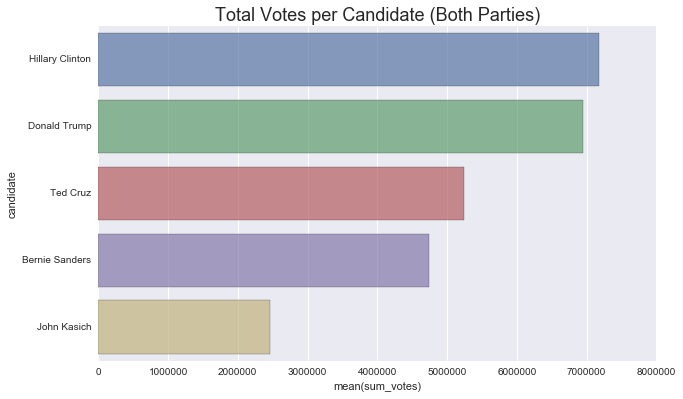

In [50]:
votes_sum = pd.read_sql_query('SELECT candidate, party, sum(votes) as sum_votes \
    FROM primary_results GROUP BY candidate, party ORDER BY sum_votes desc, party;',db)
#Candidate who suspended campaign: (drop from df)
to_del = votes_sum.loc[votes_sum['candidate'].isin(['Jeb_Bush', 'Ben_Carson','Rand_Paul',
    'Chris_Christie','Carly_Fiorina','Rick_Santorum','Mike_Huckabee',
    "Martin_O'Malley",'Marco_Rubio','_No_Preference','_Uncommitted'])].index.tolist()
votes = votes_sum.drop(to_del)
votes['candidate'] = votes['candidate'].str.replace("_"," ")

#Plots
sns.plt.figure(figsize=(10,6))
sns.barplot(y = 'candidate', x = 'sum_votes', data = votes, alpha=0.7)
sns.plt.title('Total Votes per Candidate (Both Parties)', fontsize = 18)


In [46]:
# republican winner by county:
rep_winner_county = pd.read_sql_query('SELECT candidate, count(candidate) \
    as count_county FROM Republican_Winner GROUP BY candidate ORDER BY count_county desc', db)
rep_winner_county['candidate'] = rep_winner_county['candidate'].str.replace('_',' ')
# democrat winner by county:
dem_winner_county = pd.read_sql_query('SELECT candidate, count(candidate) \
    as count_county FROM Democrat_Winner GROUP BY candidate ORDER BY count_county desc', db)
dem_winner_county['candidate'] = dem_winner_county['candidate'].str.replace('_',' ')
print rep_winner_county

      candidate  count_county
0  Donald Trump           714
1      Ted Cruz           387
2   John Kasich            39
3   Marco Rubio            20
4    Ben Carson             1
5     candidate             1


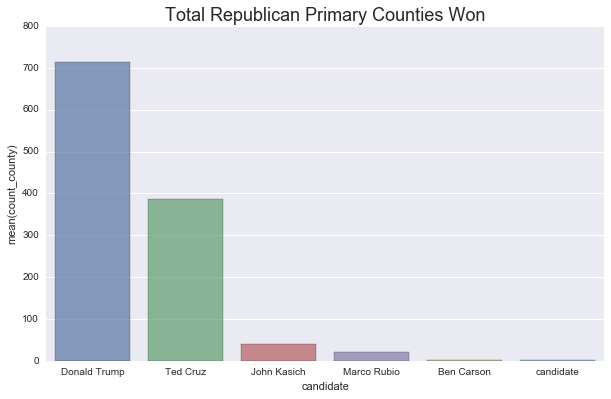

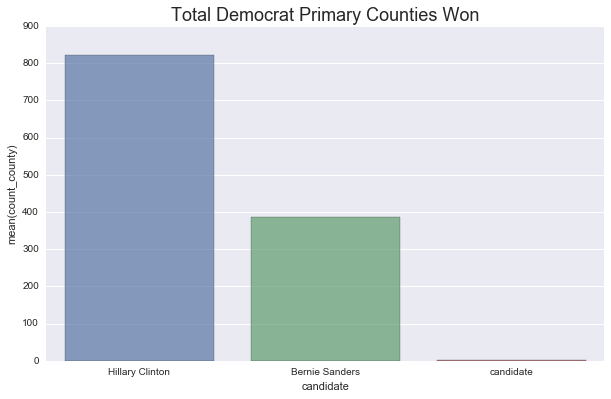

In [51]:
#plots
sns.plt.figure(figsize=(10,6))
sns.barplot(x = 'candidate', y = 'count_county', data = rep_winner_county, alpha = 0.7)
sns.plt.title('Total Republican Primary Counties Won', fontsize = 18)

sns.plt.figure(figsize=(10,6))
sns.barplot(x = 'candidate', y = 'count_county', data = dem_winner_county, alpha=0.7)
sns.plt.title('Total Democrat Primary Counties Won', fontsize = 18)

### Preprocess Data:

- Initially the tables is the database were not assigned with a primary or foreign key, thus as a quick fix instead of recreating the tables, a single column was added that consisted of merging the county and state abbreviation columns together to give a unique ID name to both the primary results and county facts table (i.e. `county_stateabbrev`); the two tables can now be linked together. Furthermore, this predictive model will focus only on candidates who are currently still in the race: Donald Trump, Ted Cruz, and John Kasich. Those candidates whom have suspended their presidential campaign were removed from the ‘republican_data’ DataFrame: Marco Rubio, Ben Carson, Jeb Bush, Rick Santorum, Rand Paul, Chris Christie, Carly Fiorina, and Mike Huckabee. An additional step in the data preprocessing was to remove columns that were repetitive when joining the Republican_Winner and county_facts table (i.e. state, state abbreviation, county). A final step is then to designate the target column and feature columns. Being that Republican_Winner table contained columns that included state, county, etc. that are not part of the features, some additional work was required to reorganize the data such that two separate DataFrames were constructed; one containing the features and the other contains the target column Using the concat function in pandas allows the two separate DataFrames to then be re-joined together in the desired format. After slicing the newly created DataFrame, `df_rep`,  X_all stores all of the features and y_all stores the target column. 

In [14]:
#RENAME COLUMNS: 
#can use the following script below to rename headers for the feature columns

#republican_data or democrat_data = republican_data.rename(columns = {
#               'PST045214':'Population 2014',
#                'PST040210':'Population 2010',
#                'PST120214':'Delta Pop (%) 2014',
#                'POP010210':'Population 2010',
#                'AGE135214':'Under 5',
#                'AGE295214':'Under 18',
#                'AGE775214':'Age > 65',
#                'SEX255214':'Female (%)',
#                'RHI125214':'White (%)',
#                'RHI225214':'Black (%)',
#                'RHI325214':'American Indian (%)',
#                'RHI425214':'Asian (%)',
#                'RHI525214':'Native Hawaiian (%)',
#                'RHI625214':'2+ Races (%)',
#                'RHI725214':'Hispanic (%)',
#                'RHI825214':'White alone (%)',
#                'POP715213':'Living same house 1+yr over (%)',
#                'POP645213':'Foreign born (%)',
#                'POP815213':'Other Languages (%)',
#                'EDU635213':'High School Degree',
#                'EDU685213':'College Degree',
#                'VET605213':'Veterans',
#                'LFE305213':'Mean travel time to work (minutes, Age>16+)',
#                'HSG010214':'Housing Units',
#                'HSG445213':'Homeownership rate',
#                'HSG096213':'Housing units in multi-unit structures (%)',
#                'HSG495213':'Med value of owner-occupied housing units (%)',
#                'HSD410213':'Households',
#                'HSD310213':'Persons per household',
#                'INC910213':'Yr. Per capita income ($)',
#                'INC110213':'Median household income ($)',
#                'PVY020213':'below poverty level (%)',
#                'BZA010213':'Private nonfarm establishments',
#                'BZA110213':'Private nonfarm employment',
#                'BZA115213':'Private nonfarm employment delta%)',
#                'NES010213':'Nonemployer establishments',
#                'SBO001207':'Total Firms',
#                'SBO315207':'Black-owned firms (%)',
#                'SBO115207':'American Indian owned firms, (%)',
#                'SBO215207':'Asian-owned firms, (%)',
#                'SBO515207':'Native Hawaiian owned firms (%)',
#                'SBO415207':'Hispanic-owned firms (%)',
#                'SBO015207':'Women-owned firms (%)',
#                'MAN450207':'Manufacturers shipments($1k)',
#                'WTN220207':'Merchant wholesaler sales ($1k)',
#                'RTN130207':'Retail sales, ($1k)',
#                'RTN131207':'Retail sales per capita',
#                'AFN120207':'Accomm & food services sales ($1K)',
#                'BPS030214':'Building permits',
#                'LND110210':'Land area in square miles',
#                'POP060210':'Population per sqmile'})

In [70]:
#Dataframe Democrat and Republican winners per county w/ county facts:

democrat_data = pd.read_csv("./election results/democrat_winners_county_facts.csv")
#drop repeated columns from merge
democrat_data.drop(democrat_data.columns[[1,3,9,10,11,63]], axis=1, inplace=True)
#republican_data['candidate'] = republican_data['candidate'].str.replace('_',' ') #to clean up plots

In [71]:
#Dataframe for Republican winners per county w/ county facts:
republican_data = pd.read_csv("./election results/republican_winners_county_facts.csv")
#drop repeated columns from merge
republican_data.drop(republican_data.columns[[1,3,9,10,11,63]], axis=1, inplace=True)

# Remove all rows wrt Republican candidates who suspended campaign:
to_del = republican_data.loc[republican_data['candidate'].isin(['Jeb_Bush', 
    'Ben_Carson','Rand_Paul','Chris_Christie','Carly_Fiorina','Rick_Santorum',
    'Mike_Huckabee',"Marco_Rubio","_No_Preference","_Uncommitted"])].index.tolist()
republican_data = republican_data.drop(to_del)

#republican_data['candidate'] = republican_data['candidate'].str.replace('_',' ') #to clean up plots

In [72]:
'''Democrats'''
x_columns_dem = list(democrat_data.columns[8:]) 
x_vars_dem = democrat_data[x_columns_dem] # Features
y_vars_dem = democrat_data['candidate'] # Target Labels
df_dem = pd.concat([x_vars_dem,y_vars_dem],axis=1) #combine Feautres/Target into one dataframe

In [73]:
'''Republicans'''
#republican_data = republican_data.replace(['Donald_Trump','Ted_Cruz','John_Kasich'],[1,2,3])
x_columns_rep = list(republican_data.columns[8:]) 
x_vars_rep = republican_data[x_columns_rep] # Features
y_vars_rep = republican_data['candidate'] # Target Labels
df_rep = pd.concat([x_vars_rep,y_vars_rep],axis=1) #combine Feautres/Target into one dataframe


### Explore the data

- It’s not the number of counties that a candidate wins to become the party’s nominee, rather accumulating the required number of delegates that are allotted by the individual states. The Democratic candidate needs 2,383 delegates (1,931 remaining) to win the nomination while the Republican nominee needs 1,237 (852 remaining).  Still a long way left to go for both parties, especially the Republicans as a potential brokered convention looms if a candidate does not reach the magical number of 1,237 delegates. The attempt now is to combine all of the election results filtered by the winner of each county with the marker size representing the magnitude of votes allocated. Being the vast number of pairwise combinations, several interesting features were explored to determine whether a strong or weak correlation exists among the candidate with the associated attribute. Given this knowledge, campaigns can then adjust their strategies to appeal towards certain demographics such that it enhances a candidate’s chances of accumulating more votes. Receiving the highest fraction of votes in a primary state leads to the candidate increasing his/her delegate count and moving that much closer into securing the nomination for their respected party. The trends observed from the 28 primary states thus far provide a benchmark on how citizens will potentially elect a nominee throughout the remaining primaries/caucuses, baring any political shakeup. The scatter plots below compare several of the demographics with the markers representing the magnitude of votes the winning candidate received for the resultant county. Hence, larger maker sizes references more densely populated areas (i.e. higher number of votes). In some cases, the medium size markers could still represent a larger populated area with a low voter turnout ratio; voter turnout information is not available in this dataset. There are numerous combinations of voter trends that can be observed based on the given attributes, therefore the following plots explore the some of the relationships such as education, income, race, and ethnicity.

In [67]:
def plot1():
    x_feat = "RHI125214"
    y_feat = "EDU685213"
    x_label = "White (%)"
    y_label = "Education (BS or Higher)"
    dem_create_plot(x_feat,y_feat,x_label,y_label)

def plot2():
    x_feat = "INC910213"
    y_feat = "EDU685213"
    x_label = "Per Capita Money Income ($)"
    y_label = "Education (BS or Higher)"
    dem_create_plot(x_feat,y_feat,x_label,y_label)
    
def plot3():
    x_feat = "INC110213"
    y_feat = "RHI225214"
    x_label = "Median household income ($)"
    y_label = "Black or African American (%)"
    dem_create_plot(x_feat,y_feat,x_label,y_label)
    
def plot4():
    x_feat = "INC110213"
    y_feat = "RHI125214"
    x_label = "Median household income ($)"
    y_label = "White (%)"
    dem_create_plot(x_feat,y_feat,x_label,y_label)
    
def dem_create_plot(x_feat,y_feat,x_label,y_label):
    hue = "candidate"
    dataframe = democrat_data
    markerSize = (democrat_data['votes']/300)
    g = sns.lmplot(x=x_feat, y=y_feat, data=dataframe, hue=hue, 
               scatter_kws={'s':markerSize,'alpha':0.7,'linewidths':1.5,'edgecolor':'w'},
                   size=5.5, aspect=1.5)
    g.set_xlabels(x_label, size = 18)
    g.set_ylabels(y_label, size = 18)
    axes = g.axes
    g.set(ylim=(0,None))
    g.set(xlim=(0,None))
    sns.plt.title('Democrat Party', fontsize = 20)

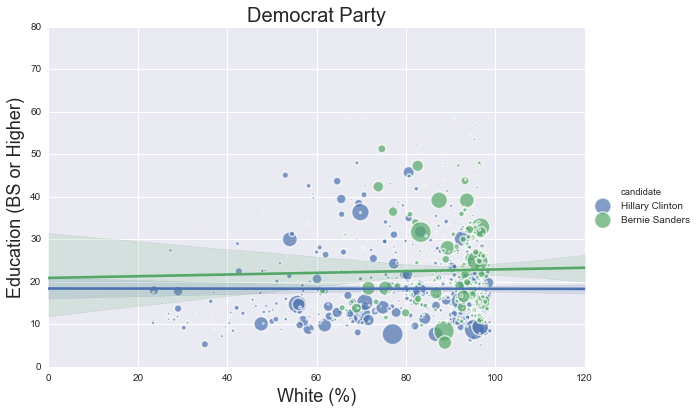

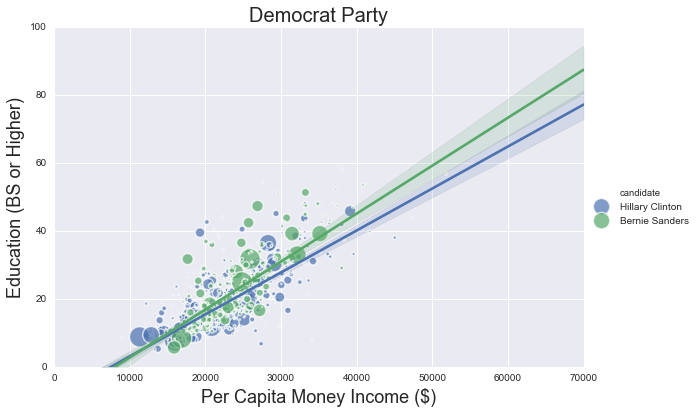

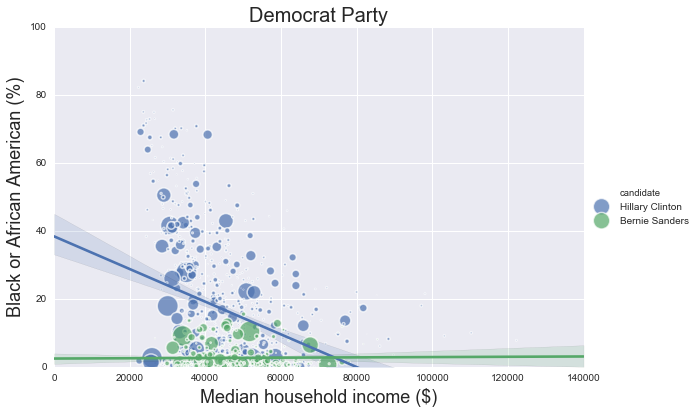

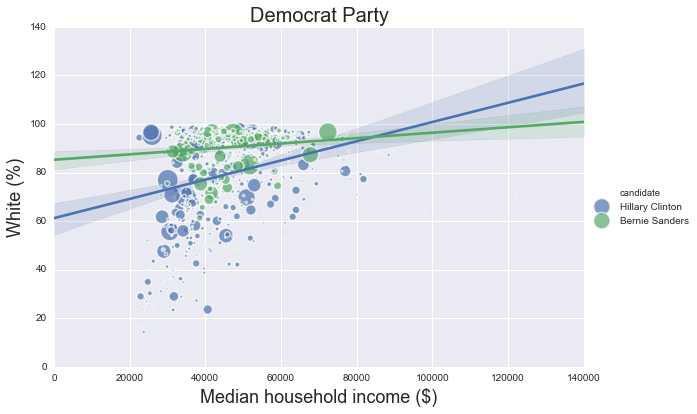

In [68]:
#Democrats
def main():
    plot1()
    plot2()
    plot3()
    plot4()
if __name__ == "__main__":
    main()

### Republican Party

In [74]:
def plot1():
    x_feat = "RHI125214"
    y_feat = "EDU685213"
    x_label = "White (%)"
    y_label = "Education (BS or Higher)"
    rep_create_plot(x_feat,y_feat,x_label,y_label)

def plot2():
    x_feat = "INC910213"
    y_feat = "EDU685213"
    x_label = "Per Capita Money Income ($)"
    y_label = "Education (BS or Higher)"
    rep_create_plot(x_feat,y_feat,x_label,y_label)
    
def plot3():
    x_feat = "INC110213"
    y_feat = "RHI225214"
    x_label = "Median household income ($)"
    y_label = "Black or African American (%)"
    rep_create_plot(x_feat,y_feat,x_label,y_label)
    
def plot4():
    x_feat = "INC110213"
    y_feat = "RHI125214"
    x_label = "Median household income ($)"
    y_label = "White (%)"
    rep_create_plot(x_feat,y_feat,x_label,y_label)

def plot5():
    x_feat = "INC110213"
    y_feat = "RHI725214"
    x_label = "Median household income ($)"
    y_label = "Hispanic(%)"
    rep_create_plot(x_feat,y_feat,x_label,y_label)

    
def rep_create_plot(x_feat,y_feat,x_label,y_label):
    hue = "candidate"
    dataframe = republican_data
    markerSize = (republican_data['votes']/300)
    g = sns.lmplot(x=x_feat, y=y_feat, data=dataframe, hue=hue, 
               scatter_kws={'s':markerSize,'alpha':0.7,'linewidths':1.5,'edgecolor':'w'},
                   size=5.5, aspect=1.5)
    g.set_xlabels(x_label, size = 18)
    g.set_ylabels(y_label, size = 18)
    axes = g.axes
    g.set(ylim=(0,100))
    g.set(xlim=(0,None))
    sns.plt.title('Republican Party', fontsize = 20)



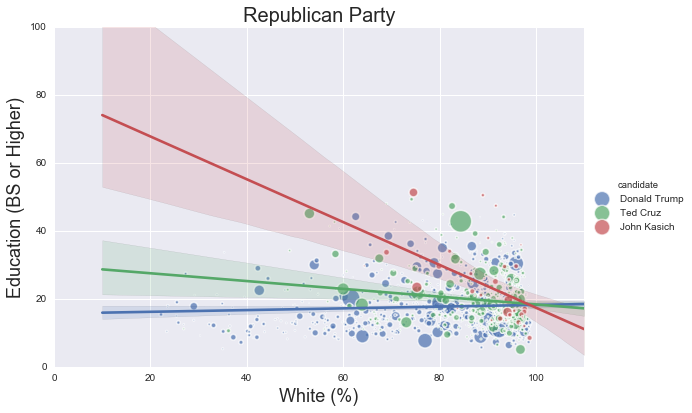

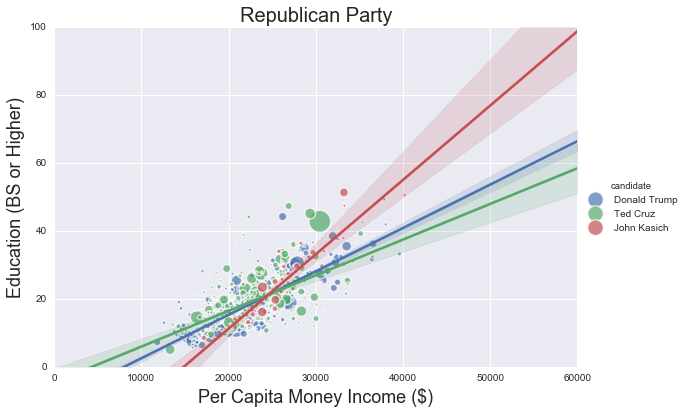

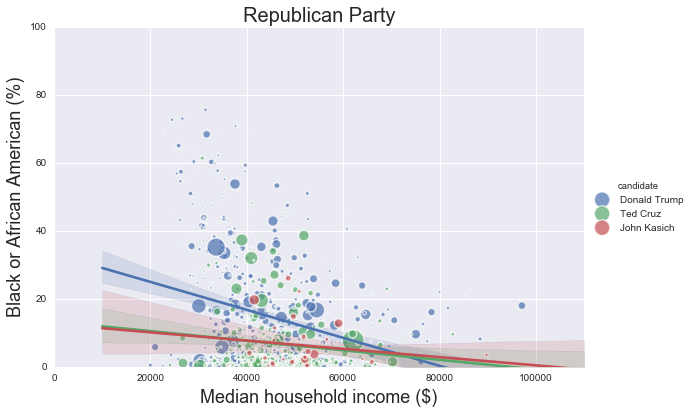

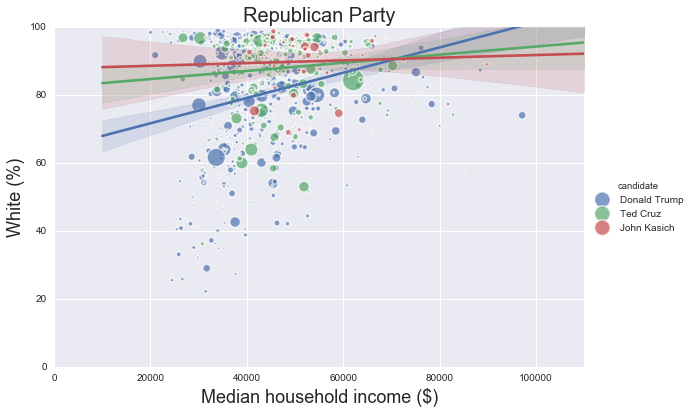

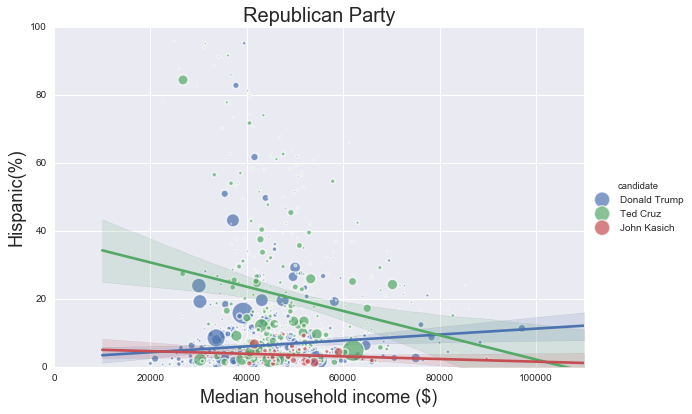

In [75]:
#Republicans
def main():
    plot1()
    plot2()
    plot3()
    plot4()
    plot5()
if __name__ == "__main__":
    main()

- Based on some of the correlation plots shown above, in summary we can see that Clinton performs better in areas with lower percentage of whites and those who possess college degrees compared to Senator Sanders who appeals to a population with higher percentages of college degrees and whites. It is also observed that Clinton does significantly better in regions with a higher percentage of African Americans with a median household income ranging between `$20-50K`. On the other side, it would be interesting to see how Trump performs compared to Senator Ted Cruz with Hispanics, given their plans regarding illegal immigration, which has been one of the leading political topics in the 2016 race. Trump outperforms Cruz in lower populated Hispanic regions (larger percentage of votes), however the trend does indicate Cruz performs slightly better in higher populated Hispanic regions with an annual median income ranging between `$30-50K`. Finally, comparing the percentage of whites versus the median income, Trump appeals more to areas with less household income and percentage of whites. Majority of Cruz’s success ranges with populations receiving `$40-60K` with a significantly higher white population that ranges from 70% to nearly 100%. 

# Calibrate Predictive Model

### Split Training/Testing Set


- As previously mentioned, the dataset is unbalanced, thus is important to address splitting the data into training and testing when initially calibrating the model. Therefore, after preprocessing the data, applying the cross-validation technique `StratifiedShuffleSplit` helps deal with the imbalance number of classes in the dataset by allowing the training and testing set to have roughly the same ratio of candidate winners; the ratio will not be evenly distributed for John Kasich due to the low number of counties won (39) so far in contrast to his counterparts Trump and Cruz who have won 714 and 387, respectively. The data is also shuffled to remove any bias in the order of candidates. `StratifiedShuffleSplit` will randomly select training and testing sets multiple times and then average the results over all the tests. Seventy-five percent of the dataset has been assigned as the training set and the remained 25% will be used as the testing set (training samples = 848, testing samples = 283). After splitting the features and target as training and testing data, the DecisionTreeClassifier, Random Forest, and SVM classifiers are implemented and fine-tuned so that the optimal performance is achieved.

In [21]:
feature_cols = list(df_rep.columns[:-1])  # all columns but last are features
target_col = df_rep.columns[-1]  # last column is the target/label

X_all = df_rep[feature_cols]  # feature values 
y_all = df_rep[target_col]  # corresponding targets/labels
num_all = df_rep.shape[0]
num_train = int(num_all - (num_all*.25))
num_test = num_all - num_train

def Stratified_Shuffle_Split(X,y,num_test):
    sss = StratifiedShuffleSplit(y, 10, test_size=num_test, random_state = 42)
    for train_index, test_index in sss:
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    return X_train, X_test, y_train, y_test
    
X_train, X_test, y_train, y_test = Stratified_Shuffle_Split(X_all, y_all, num_test)
print "Training Set: {0:.2f} Samples".format(X_train.shape[0])
print "Testing Set: {0:.2f} Samples".format(X_test.shape[0])


Training Set: 848.00 Samples
Testing Set: 283.00 Samples


### Decision Tree: Classification

In [22]:
def learning_curve(X_train, y_train, X_test, y_test):
    depth = range(1,11)
    for d in depth: 
        sizes = range(1, len(X_train), 50)
        test = []
        train = []
        size = []
        for i in sizes:
            # Create and fit the decision tree regressor model
            clf = tree.DecisionTreeClassifier(max_depth = d, random_state=None)
            clf.fit(X_train[:i], y_train[:i])
            y_pred_train = clf.predict(X_train[:i])
            y_pred_test = clf.predict(X_test[:i])
            y_true_train = y_train[:i]
            y_true_test = y_test[:i]
            test.append(accuracy_score(y_true_test, y_pred_test))
            train.append(accuracy_score(y_true_train, y_pred_train))
            size.append(sizes)
        
        acc_test = test
        acc_train = train
        test_error = 1 - pd.Series(acc_test)
        train_error = 1 - pd.Series(acc_train)
        size_ = pd.Series(sizes)
        plot_learning_curve(size_,train_error,test_error,d)
    

def plot_learning_curve(size_,train_error,test_error,d):
    pl.figure()
    pl.figure(figsize=(8,6))
    pl.title('Performance vs Training Size (Depth: %s)' % d, fontsize = 20)
    pl.plot(size_, test_error, lw=3, label = 'Test Error')
    pl.plot(size_, train_error, lw=3, label = 'Training Error')
    pl.legend()
    pl.xlabel('Training Size', fontsize = 14)
    pl.ylabel('Error %', fontsize =14)
    pl.show()

- As the decision tree grows and becomes more complex the issue of overfitting arises. In this scenario, the model has virtually memorized the training data but will not be expected to perform well with out-of-sample data. On the other hand, if the tree is too simple then this could result in underfitting as the learning value is restricted to one level of the decision tree and does not allow the training set to learn the data adequately; a lower complexity decision tree results in high bias. To address the effect of either over or under fitting, a plot of the maximum depth of the tree versus the accuracy error (1-accuarcy) was generated. As observed form the figures below, the training error is virtually zero as the model has basically memorized the small training set. However, as more data is added to the model, the training error begins to increase. When the training size increases, error begins to increase and the high error translates to underfitting the data; likewise, the low training error would indicate overfitting the data. The testing error is relatively high initially because it has not seen enough examples, but begins to decrease as more training examples are given. With that said, the best max_depth to consider for the classifier is 5. (plots shown below)

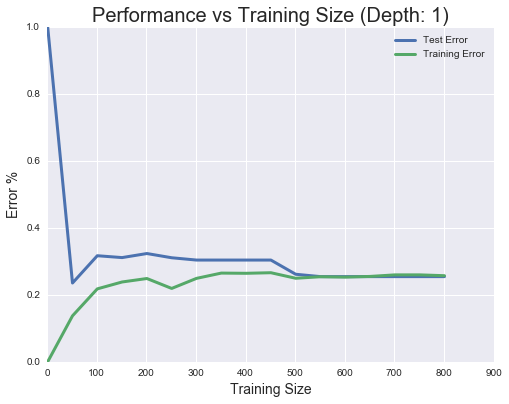

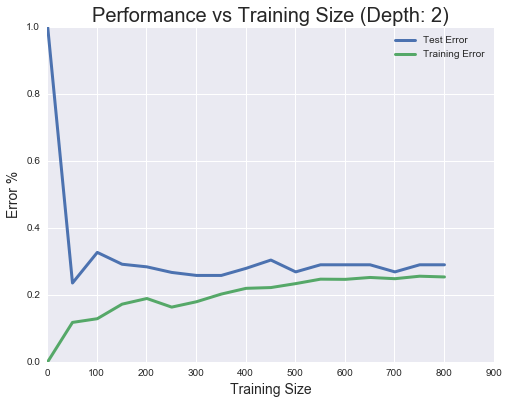

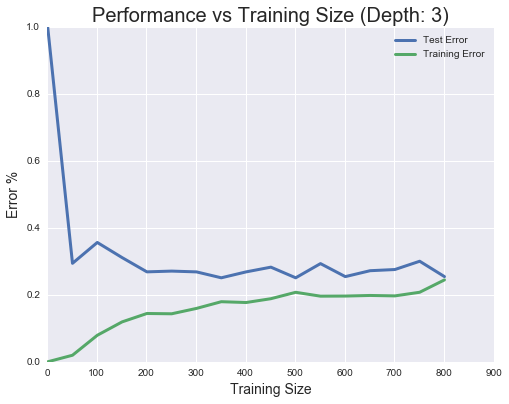

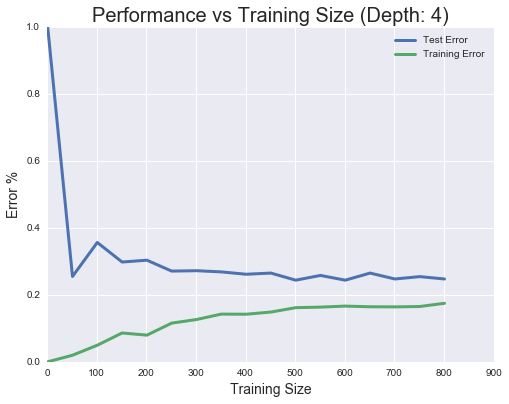

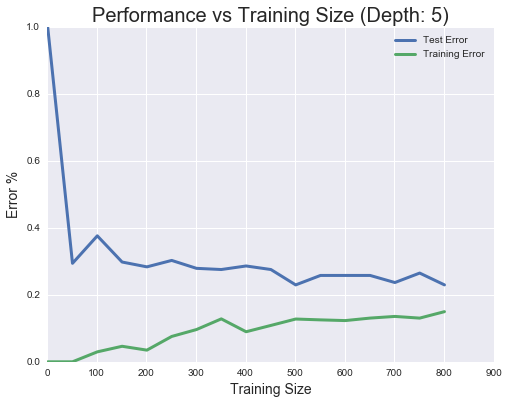

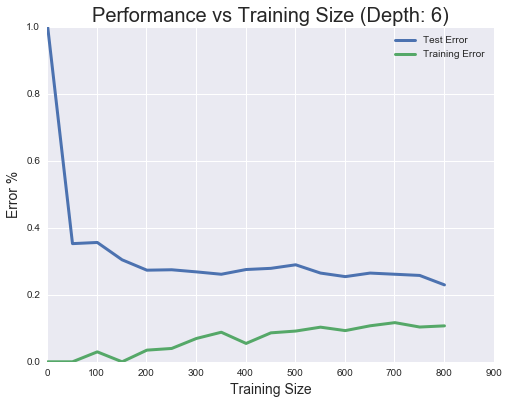

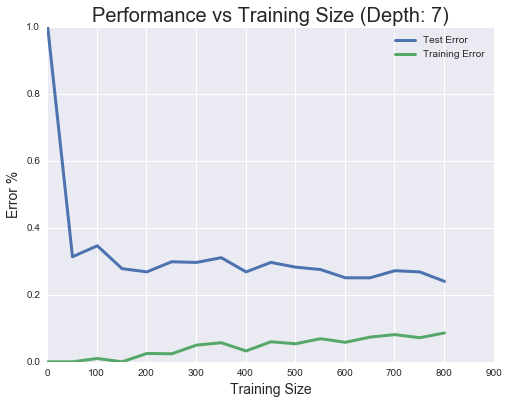

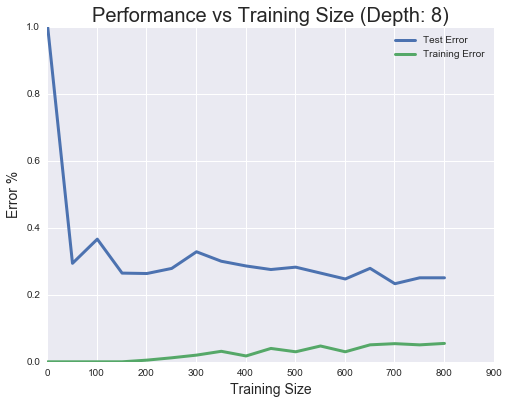

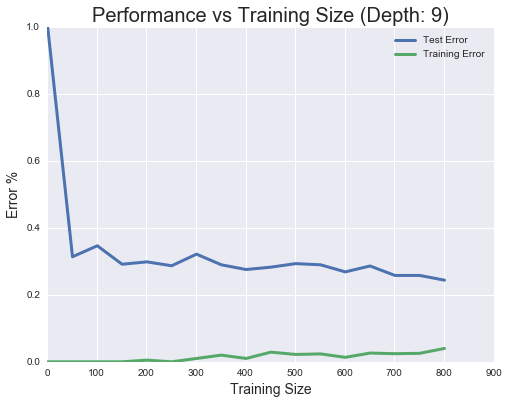

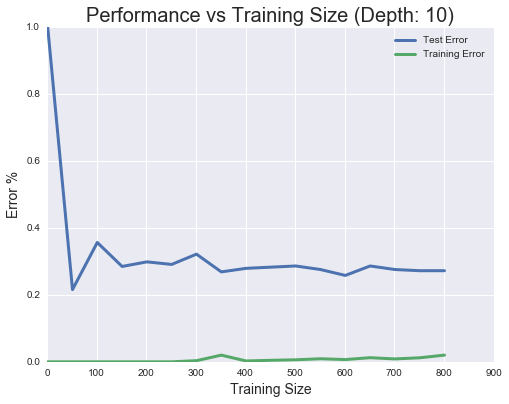

In [23]:
learning_curve(X_train, y_train, X_test, y_test)

- Additionally, a plot was created of the max_depth vs the cross-validation score (scoring = ‘accuracy’) located in the bottom right (red line). Cross-validation is the process of dividing the data into folds (cv = 10) and hold out one of the folds as a test set and the remaining folds are used as the training set. This process is repeated until each fold is a test set and the score is then averaged. This graph shows that by increasing the complexity of the tree beyond a max_depth of 4-5 reduces the classifier’s performance. As a note, when implementing CV, the cross_val_score performed the best when taking the training set (X_train, y_train) as an input, which had already been split using Stratified_Shuffle_Split().

In [24]:
def cross_validation(X_train, y_train, X_test, y_test):
    n_depth = []
    accuracy = []
    for depth in range (1,11):
        clf = tree.DecisionTreeClassifier(max_depth = depth, 
        min_samples_split = 20, min_samples_leaf = 20, random_state=None)
        #if clf.fit(X_train,y_train).tree_.max_depth < depth:
        #    break
        score = np.mean(cross_val_score(clf,X_train,y_train,
                scoring ='accuracy', n_jobs=1))
        scoring = round(score,4)
        accuracy.append(scoring)
        n_depth.append(depth)
        print 'Depth: %i Accuracy: %.4f' % (depth,score)
    DT_max_depth_plot(accuracy,n_depth)

def DT_max_depth_plot(accuracy,n_depth):
    pl.figure(figsize=(8,6))
    pl.plot(n_depth, accuracy, color='r',lw=3, label = "Accuracy")
    pl.title("Decision Tree: Max_Depth", fontsize = 18)
    pl.xlabel("max_depth", fontsize =14)
    pl.ylabel("Accuracy", fontsize =14)
    pl.xlim(1,10)
    pl.legend(loc = "upper right")
    pl.tight_layout()
    pl.show()

Depth: 1 Accuracy: 0.7264
Depth: 2 Accuracy: 0.7252
Depth: 3 Accuracy: 0.7359
Depth: 4 Accuracy: 0.7665
Depth: 5 Accuracy: 0.7571
Depth: 6 Accuracy: 0.7571
Depth: 7 Accuracy: 0.7558
Depth: 8 Accuracy: 0.7558
Depth: 9 Accuracy: 0.7547
Depth: 10 Accuracy: 0.7558


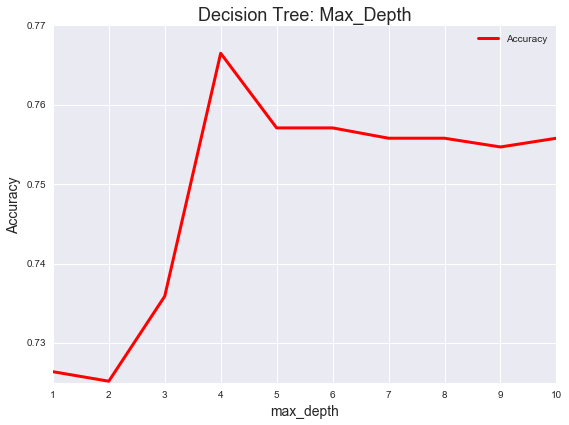

In [25]:
cross_validation(X_train, y_train, X_test, y_test)

In [91]:
def DT_tune_model(number_runs):

    clf_ = DecisionTreeClassifier()
    print "{}....".format(clf_.__class__.__name__)
    f1_scores_test = []
    
    for num in range(1, number_runs):
        print "\n Iteration: %s" % num
        X_train, X_test, y_train, y_test = Stratified_Shuffle_Split(X_all, y_all, num_test)
        start_time = time.time()
        
        '''Parameters:'''
        parameters = {'max_depth':list(range(4,6)),
                    'min_samples_leaf':(2,4,6,8,10,15,20,25,30),
                    'min_samples_split':(2,4,6,8,10,15,20,25,30)}
    
        #train classifier
        score = 'f1'
        clf = GridSearchCV(clf_, parameters, cv=5, scoring='%s_weighted' % score)
        clf.fit(X_train, y_train)
        print "Best Parameters:", clf.best_params_
        print "Best F1 score (training set): %s" % (round((clf.best_score_),3))
        
        #Predict on testing:
        y_true, y_pred = y_test, clf.predict(X_test)
        f1_scores_test.append(round(f1_score(y_test, y_pred, average='weighted'),3)) #f1 score
        
        
        print "F1 Score (testing set): %s" % (round(f1_score(y_test, y_pred, average='weighted'),4))
    
    print "\nClassification Report:"
    print classification_report(y_true, y_pred)
    print "**************************************"
    
    df = pd.Series(f1_scores_test)
    print "\n F1 Scores:"
    print df
    print "\nAverage F1 Score:"
    print df.mean()
    end_time = time.time()
    total_time = end_time - start_time
    m, s = divmod(total_time, 60)
    h, m = divmod(m, 60)
    print "\nTotal Time: %d:%02d:%02d" % (h, m, s) #hours:minutes:second

In [92]:
DT_tune_model(6)

DecisionTreeClassifier....

 Iteration: 1
Best Parameters: {'min_samples_split': 2, 'max_depth': 5, 'min_samples_leaf': 20}
Best F1 score (training set): 0.768
F1 Score (testing set): 0.7394

 Iteration: 2
Best Parameters: {'min_samples_split': 4, 'max_depth': 5, 'min_samples_leaf': 20}
Best F1 score (training set): 0.768
F1 Score (testing set): 0.7394

 Iteration: 3
Best Parameters: {'min_samples_split': 4, 'max_depth': 5, 'min_samples_leaf': 20}
Best F1 score (training set): 0.768
F1 Score (testing set): 0.7394

 Iteration: 4
Best Parameters: {'min_samples_split': 2, 'max_depth': 5, 'min_samples_leaf': 20}
Best F1 score (training set): 0.768
F1 Score (testing set): 0.7394

 Iteration: 5
Best Parameters: {'min_samples_split': 4, 'max_depth': 5, 'min_samples_leaf': 20}
Best F1 score (training set): 0.768
F1 Score (testing set): 0.7394

Classification Report:
             precision    recall  f1-score   support

Donald_Trump       0.75      0.92      0.83       177
John_Kasich       0.0

### Construct Decision Tree

Apr 21 00:01:43 Trace-Smiths-MacBook-Pro.local dot[6000] <Error>: The function ‘CGFontGetGlyphPath’ is obsolete and will be removed in an upcoming update. Unfortunately, this application, or a library it uses, is using this obsolete function, and is thereby contributing to an overall degradation of system performance.
Apr 21 00:01:43 Trace-Smiths-MacBook-Pro.local dot[6000] <Error>: The function ‘CGFontGetGlyphPaths’ is obsolete and will be removed in an upcoming update. Unfortunately, this application, or a library it uses, is using this obsolete function, and is thereby contributing to an overall degradation of system performance.



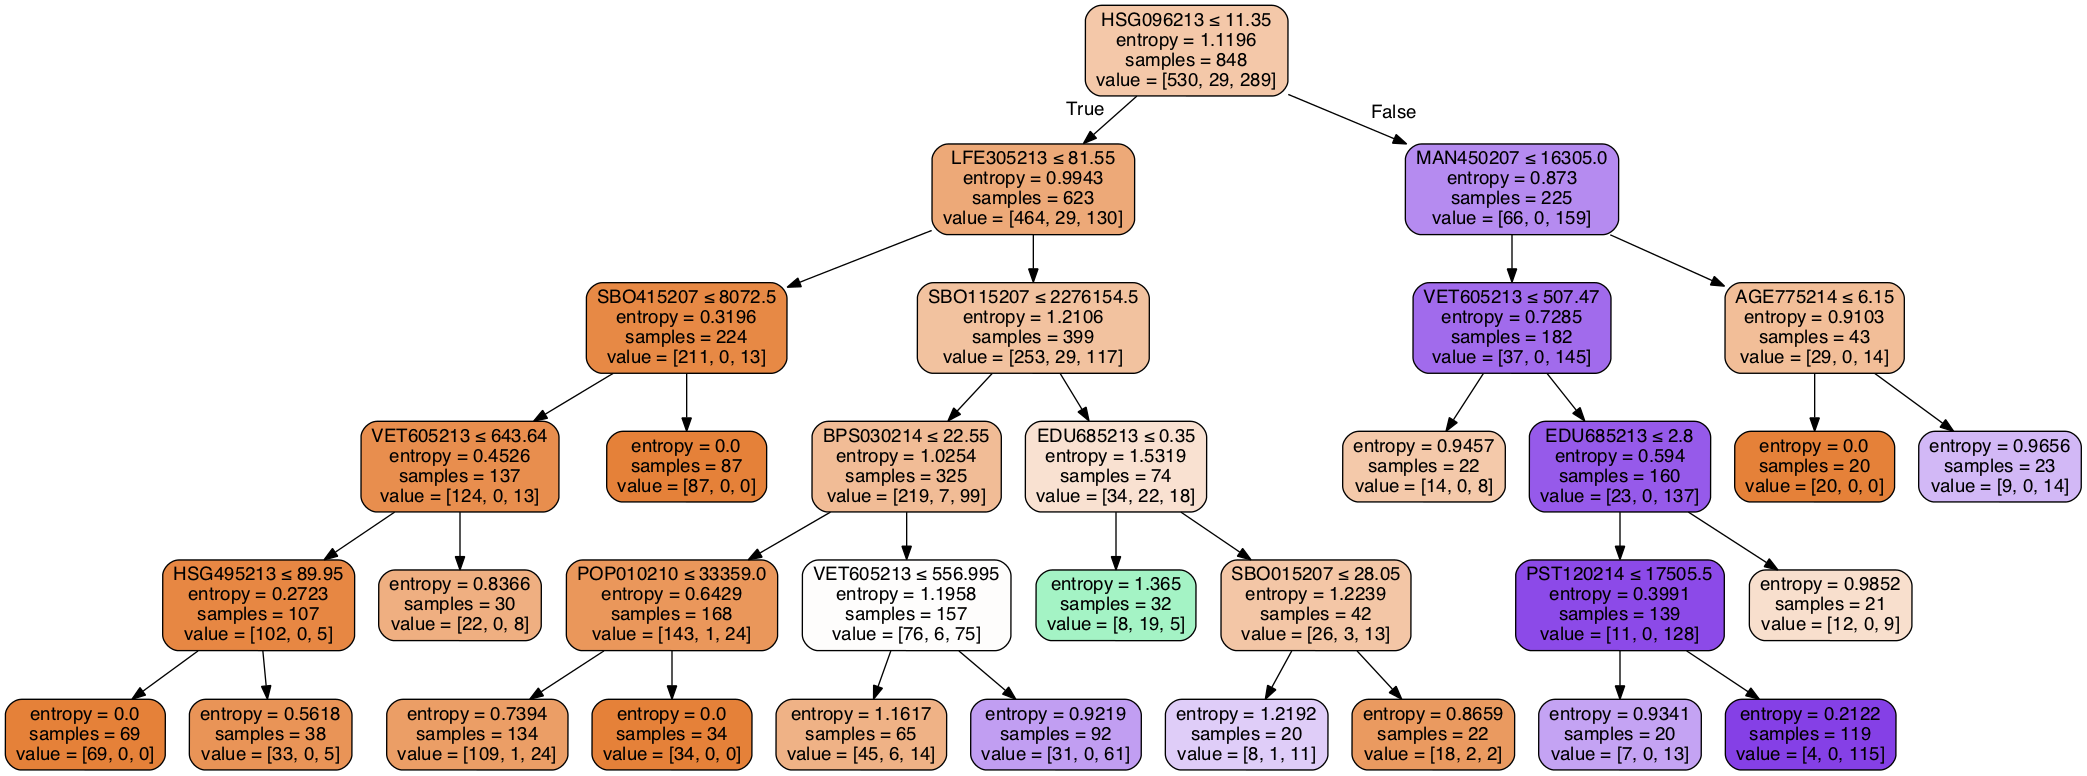

In [28]:
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth = 5, min_samples_split=4,min_samples_leaf=20)
clf = clf.fit(X_train, y_train)
    
'''Add Labels to Features'''
df_rep_dt = df_rep
    #df_rep_dt.drop('candidate',axis=1,inplace = True) #drop target column
list_of_dic = df_rep_dt.T.to_dict().values()
vec = DictVectorizer()
vec.fit_transform(list_of_dic).toarray()
feature_names = vec.get_feature_names()
    
'''Add Target Labels'''
target_names = ['Donald_Trump','Ted_Cruz','John_Kasich']

with open("decision_tree.dot", 'w') as f:
    f = tree.export_graphviz(clf, out_file=f)
        
os.unlink('tree.dot')
    
dot_data = StringIO() 
tree.export_graphviz(clf, out_file=dot_data,feature_names=vec.get_feature_names(),  
                             class_names=target_names) 
graph = pydot.graph_from_dot_data(dot_data.getvalue()) 
graph.write_pdf("decision_tree.pdf") 


dot_data = StringIO()  
tree.export_graphviz(clf, out_file=dot_data,  
                             feature_names=vec.get_feature_names(),  
                             #class_names=target_names,  
                             filled=True, rounded=True,  
                             special_characters=True)  
graph = pydot.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png()) 

To execute the visualization of the decision tree (above), installing the Graphviz package is required in addition to PyGraphviz, which is a Python interface to the Graphviz graph layout and visualization package. The script to create the tree can be found under the `Construct Decision Tree` heading in the analysis.ipynb. Also, the `tree.pdf` file in the main directory contains the decision tree. A description of the features shown in the tree can be found in the Appendix. As shown above, “the number of housing units in multi-unit structures” (i.e. the percentage of apartments, townhomes in a county) is the most influential feature and is the root of the decision tree based on the DecisionTreeClassification using the splitting criteria of entropy as previously discussed. We can start at the root of the tree and move down the branches until reaching a terminal leaf in order to determine which Republican candidate is associated with demographics of a county located in the United States. The terminal or ‘leaf’ node at the bottom of the tree is referred to as the decision node and is dominated by one class and the value is ordered as follows [Trump, Kasich, Cruz]. 

### Random Forest

- Predictions of decision trees tend to have a higher variance which is why the Random Forest algorithm was included in this work. The addition of more trees can result in reducing the overall variance and does not tend to overfit as easily. Also, being that our dataset contains a large set of features, a useful approach to determine which features are the most relevant is to use Random Forest by calling the `clf.feature_importances_ function` from Sklearn.

In [104]:
#Run Model: (w/out Gridsearch)
def run_rf(number_runs):
    
    clf = RandomForestClassifier(n_estimators = 100)
    print "{}....\n".format(clf.__class__.__name__)
    names = feature_cols
    df = pd.DataFrame(columns = [
                    'Training_Size',
                    'Testing_Size',
                    'F1_Score_Testing'])

    X_train, X_test, y_train, y_test = Stratified_Shuffle_Split(X_all, y_all, num_test)
        
    sizes = [X_train.shape[0]] #can change training/testing size
    for size in sizes: 
        for x in range(0, number_runs): 
            start_time = time.time()
            clf.fit(X_train, y_train)
            pred = clf.predict(X_test)
            f1_score_test = round(f1_score(y_test, pred, average='weighted'),3) #f1 score
            
            print "Iteration: %s" % (x+1)
            
            print "F1_Score:", f1_score_test
            
            end_time = time.time()
            total_time = round((end_time - start_time),3)
            print "Total Time (seconds): %s" % total_time #seconds
               
            df = df.append({
                    'Training_Size': len(X_train[:size]),
                    'Testing_Size': X_test.shape[0],
                    'F1_Score_Testing': f1_score_test}, 
                    ignore_index= True)
        
            '''Confusion Matrix: Testing Set'''
            y_pred = clf.fit(X_train, y_train).predict(X_test)
            cm = confusion_matrix(y_test, y_pred, 
                            labels = ["Donald_Trump","John_Kasich","Ted_Cruz"])
            print "Confusion Matrix:"
            print cm
            print "**********************************" 

            #Feature Importance:
            feature_imp = sorted(zip(map(lambda x: round(x, 4), clf.feature_importances_), names), 
                                                                                    reverse=True)   
        #mean statistics:
        df = df[(df.Training_Size == size)]
        df_mean = df.mean()
        print "Mean Statistics:"
        print df_mean
            
        #Feature Importance 
        columns = ['Importance','Feature']
        df_imp = pd.DataFrame(feature_imp, columns = columns)
        print "**********************************"
        print "Feature Importance:"
        print df_imp
        pl.figure
        feature_plot(df_imp)
        
def feature_plot(df_imp):
    ax = df_imp.plot(x='Feature', y='Importance',kind='bar',
        figsize=(8,6), color= 'b',
        alpha= 0.8, legend=True)
    ax.set_title('Feature Importance', fontsize = 24)
    ax.set_ylabel('Importance', fontsize= 16)
    ax.set_xlabel('Feature',fontsize= 16)
    pl.tight_layout()
    pl.show()

RandomForestClassifier....

Iteration: 1
F1_Score: 0.801
Total Time (seconds): 0.912
Confusion Matrix:
[[161   1  15]
 [  8   1   1]
 [ 32   0  64]]
**********************************
Iteration: 2
F1_Score: 0.796
Total Time (seconds): 0.794
Confusion Matrix:
[[164   1  12]
 [  7   3   0]
 [ 33   0  63]]
**********************************
Iteration: 3
F1_Score: 0.81
Total Time (seconds): 0.767
Confusion Matrix:
[[163   1  13]
 [  7   2   1]
 [ 32   0  64]]
**********************************
Iteration: 4
F1_Score: 0.784
Total Time (seconds): 0.76
Confusion Matrix:
[[163   1  13]
 [  8   2   0]
 [ 31   0  65]]
**********************************
Iteration: 5
F1_Score: 0.799
Total Time (seconds): 0.862
Confusion Matrix:
[[160   1  16]
 [  8   2   0]
 [ 32   0  64]]
**********************************
Iteration: 6
F1_Score: 0.8
Total Time (seconds): 0.885
Confusion Matrix:
[[161   1  15]
 [  8   2   0]
 [ 32   0  64]]
**********************************
Iteration: 7
F1_Score: 0.813
Total Time 

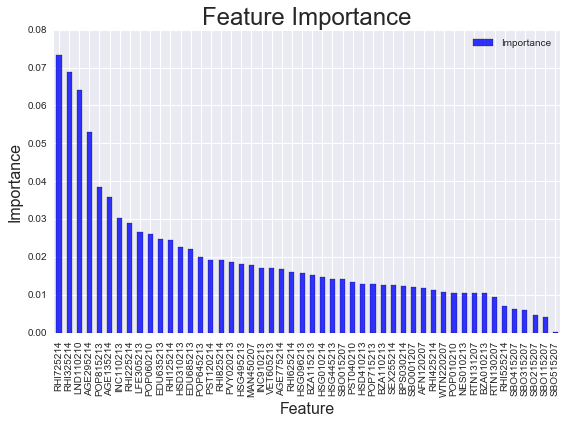

In [105]:
run_rf(10)

 From the bar plot, the top three most relevant features are Hispanic population, age population under 18 years old, and total land area (square miles). A larger land mass feature makes sense, being that a larger magnitude of votes would be expected to come from that region, thus being more influential than less populated areas. The remaining features decline exponentially and remain relatively flat after the first 4-6 features. It is implicit that irrelevant features can reduce the accuracy and efficiency (run time) of the classifier. In the Random Forest model, it was decided to include all of the features; preliminary runs with only the first 10-15 features did not result in significantly improving the F1 score. 

### Fine Tune Random Forest Model:

- Initially running the Random Forest model without fine-tuning and with 100 trees yielded an average F1 score of 0.79 on the testing samples after 10 iterations, which is as slight improvement to the DecisionTreeClassifier. Next, in an attempt to optimize the performance of the RF classifier, GridSearch was applied and the following hyperparameters were tuned: 


    - 'Max_depth' [3,4,5,6,7]
    - 'Min_samples_leaf': [2,4,6,8,10,15,20,25,30]
    - 'Min_samples_split': [2,4,6,8,10,15,20,25,30]

In [102]:
#Tune Model Using GridSearch
def rf_tune_model(number_runs): 
    clf = RandomForestClassifier(n_estimators = 100)
    for num in range(0, number_runs):
        start = time.time()
        X_train, X_test, y_train, y_test = Stratified_Shuffle_Split(X_all, y_all, num_test)
        start_time = time.time()
        '''Parameters:'''
        parameters = {'max_depth':list(range(3,7)),
                    'min_samples_leaf':(2,4,6,8,10,15,20,25,30),
                    'min_samples_split':(2,4,6,8,10,15,20,25,30)}
     
        #train classifier
        score = 'f1'
        clf_ = GridSearchCV(clf, parameters, cv=5, scoring='%s_weighted' % score)
        clf_.fit(X_train, y_train)
        print "Best score (training set): %s \n" % (round((clf_.best_score_),3))
        print "Best Parameters:"
        print clf_.best_params_

        #Predict on testing:
        y_true, y_pred = y_test, clf_.predict(X_test)
        f1_scores_test = round(f1_score(y_test, y_pred, average='weighted'),3) #f1 score
        print "\nF1_score (testing set): %s" % (f1_scores_test)

        #Classification Report:
        print "\nClassification Report:"
        print classification_report(y_true, y_pred)

        #Confusion Matrix
        cm = confusion_matrix(y_test, y_pred, 
                            labels = ["Donald_Trump","John_Kasich","Ted_Cruz"])
        plot_confusion_matrix(cm, title='Confusion Matrix')
        
        #Record total run time:
        end = time.time()
        total_time = end - start
        m, s = divmod(total_time, 60)
        h, m = divmod(m, 60)
        print "Total Time: %d:%02d:%02d" % (h, m, s)

def plot_confusion_matrix(cm, title='Confusion Matrix'):
    names_x = ['Trump','Kasich','Cruz']
    names_y = ['Cruz','Kasich','Trump']
    sns.heatmap(cm,annot=True, fmt='',cmap=pl.cm.Blues)
    pl.title(title, fontsize =20)
    tick_marks_x = np.arange(len(names_x))
    tick_marks_y = np.arange(len(names_y))
    pl.xticks(tick_marks_x,names_x, rotation=45)
    pl.yticks(tick_marks_y,names_y)
    pl.tight_layout()
    pl.ylabel('True label', fontsize =14)
    pl.xlabel('Predicted label', fontsize =14)

Best score (training set): 0.782 

Best Parameters:
{'min_samples_split': 6, 'max_depth': 6, 'min_samples_leaf': 2}

F1_score (testing set): 0.783

Classification Report:
             precision    recall  f1-score   support

Donald_Trump       0.79      0.93      0.85       177
John_Kasich       0.00      0.00      0.00        10
   Ted_Cruz       0.83      0.66      0.73        96

avg / total       0.78      0.80      0.78       283

Total Time: 0:18:13


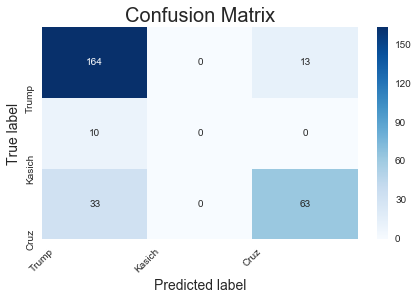

In [103]:
rf_tune_model(1)

- Once tuning the hyperparameters with 100 trees (n_estimators), the F1 score was 0.78, slightly better than the DecisionTreeClassifier, with a run time of 18 minutes. This result is for a single iteration, so the average of say 10 different iterations could be slightly higher and closer to 0.80. Reducing the number of trees down to 50 would drastically reduce the run time. Note: if we take a look at the OOB error rate vs the number of trees, the error rate begins to plateau when more than 50 trees is added to the forest, hence reducing the n_estimators to 50 could cut the computation run time down quite a bit without affecting the performance

### Out of Bag Error Rate (Random Forest)

In [31]:
def num_estimators():
    n_estimator = []
    error_rate = []
    min_estimator = 1
    max_estimator = 200
    X_train, X_test, y_train, y_test = Stratified_Shuffle_Split(X_all, y_all, num_test)
    sizes = [X_train.shape[0]] #can change training/testing size
    start = time.time()
    for size in sizes:
        for i in range(min_estimator, max_estimator):
            clf = RandomForestClassifier(max_features=None, oob_score=True,random_state=None)
            clf.set_params(n_estimators=i)
            clf.fit(X_train, y_train).predict(X_test)
            oob_error = round((1 - clf.oob_score_),3)
            n_estimator.append(i)
            error_rate.append(oob_error)
    end = time.time()
    total_time = (end-start)
    m, s = divmod(total_time, 60)
    h, m = divmod(m, 60)
    print "Total Time: %d:%02d:%02d" % (h, m, s) #hours:minutes:seconds
    #print n_estimator 
    #print error_rate
    pl.figure
    error_plot(n_estimator,error_rate,min_estimator,max_estimator)
    
def error_plot(n_estimator,error_rate,min_estimator,max_estimator):
        pl.figure(figsize=(8,6))
        pl.plot(n_estimator,error_rate, linewidth=3, color = 'g', label='Random Forrest')
        pl.ylim(0,.5)
        pl.xlim(min_estimator,max_estimator)
        pl.title('Random Forest: Error Rate', fontsize = 18)
        pl.xlabel("num_estimators", fontsize = 14)
        pl.ylabel("OOB Error Rate", fontsize = 14)
        pl.tight_layout()
        pl.legend(loc="upper right",fontsize =12)
        pl.show()

Total Time: 0:27:52


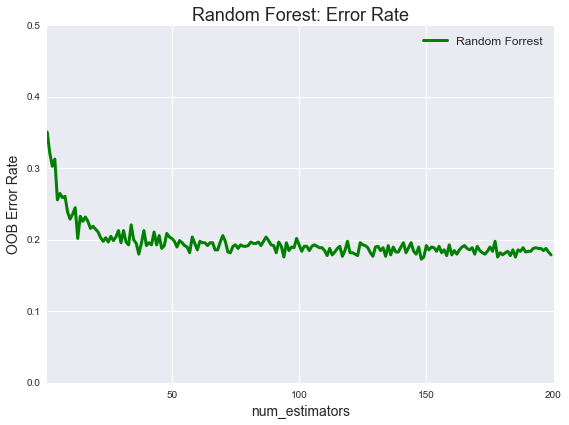

In [32]:
num_estimators()

- To validate the Random Forest model, we will take a look at the out-of-bag (OOB) error versus the number of trees. First, we do not need to apply any type of separating test (i.e. cross-validation) to get an unbiased estimate of the testing error; the random forest algorithm already addresses this. As each tree is constructed from a different bootstrap sample of the original dataset, each tree is trained with about 2/3 of the total training set. The next step is to predict the classification of the remaining 1/3 using the tree, and calculate the misclassification rate (out of bag error rate). The OOB error from the entire forest is then aggregated to determine the overall error rate. From the plot below, we can observe that the as the number of trees grows beyond 50, the OOB error levels out around 20%. Therefore, the RF model correctly predicts the Republican candidate 78-80% of the time.

### Support Vector Machines

In [93]:
def run_svc(number_runs):
    names = feature_cols
    df = pd.DataFrame(columns = [
                    'Training_Size',
                    'Testing_Size',
                    'F1_Score_Testing'])

    X_train, X_test, y_train, y_test = Stratified_Shuffle_Split(X_all, y_all, num_test)
        
    sizes = [X_train.shape[0]] #can change training/testing size
    for size in sizes: 
        for x in range(0, number_runs): 
            start_time = time.time()
            clf = SVC()
            clf.fit(X_train, y_train)
            pred = clf.predict(X_test)
            f1_score_test = round(f1_score(y_test, pred, average='weighted'),3) #f1 score
            print "Iteration: %s" % (x+1)
            print "F1_Score:", f1_score_test
            end_time = time.time()
            total_time = round((end_time - start_time),3)
            print "Total Time (seconds): %s" % total_time #seconds
               
            df = df.append({
                    'Training_Size': len(X_train[:size]),
                    'Testing_Size': X_test.shape[0],
                    'F1_Score_Testing': f1_score_test}, 
                    ignore_index= True)
        
            '''Confusion Matrix: Testing Set'''
            y_pred = clf.fit(X_train, y_train).predict(X_test)
            cm = confusion_matrix(y_test, y_pred, 
                            labels = ["Donald_Trump","John_Kasich","Ted_Cruz"])
            print "Confusion Matrix:"
            print cm
            print "**********************************" 
            
        #mean statistics:
        df = df[(df.Training_Size == size)]
        df_mean = df.mean()
        print "Mean Statistics:"
        print df_mean

In [94]:
# Run SVC model without GridSearch...
run_svc(10)

Iteration: 1
F1_Score: 0.481
Total Time (seconds): 0.316
Confusion Matrix:
[[177   0   0]
 [ 10   0   0]
 [ 96   0   0]]
**********************************
Iteration: 2
F1_Score: 0.481
Total Time (seconds): 0.41
Confusion Matrix:
[[177   0   0]
 [ 10   0   0]
 [ 96   0   0]]
**********************************
Iteration: 3
F1_Score: 0.481
Total Time (seconds): 0.364
Confusion Matrix:
[[177   0   0]
 [ 10   0   0]
 [ 96   0   0]]
**********************************
Iteration: 4
F1_Score: 0.481
Total Time (seconds): 0.333
Confusion Matrix:
[[177   0   0]
 [ 10   0   0]
 [ 96   0   0]]
**********************************
Iteration: 5
F1_Score: 0.481
Total Time (seconds): 0.295
Confusion Matrix:
[[177   0   0]
 [ 10   0   0]
 [ 96   0   0]]
**********************************
Iteration: 6
F1_Score: 0.481
Total Time (seconds): 0.265
Confusion Matrix:
[[177   0   0]
 [ 10   0   0]
 [ 96   0   0]]
**********************************
Iteration: 7
F1_Score: 0.481
Total Time (seconds): 0.348
Confusio

In [95]:
#Tune Model Using GridSearch
def SVC_tune_model(number_runs):
    f1_scores_test = []
    clf = SVC()
    for num in range(0, number_runs):
        start = time.time()
        X_train, X_test, y_train, y_test = Stratified_Shuffle_Split(X_all, y_all, num_test)
        start_time = time.time()
        '''Parameters:'''
        parameters = {'C':[1,10,50,100,200,300,400,500,1000],
                         'gamma':[1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1],
                         'kernel': ['rbf']}
        #train classifier
        score = 'f1'
        clf_ = GridSearchCV(clf, parameters, cv=5, scoring='%s_weighted' % score)
        clf_.fit(X_train, y_train)
        print "Best score (training set): %s \n" % (round((clf_.best_score_),3))
        print "Best Parameters:"
        print clf_.best_params_

        #Predict on testing:
        y_true, y_pred = y_test, clf_.predict(X_test)
        f1_scores_test.append(round(f1_score(y_test, y_pred, average='weighted'),3)) #f1 score
        print "\nF1_score (testing set): %s" % (round(f1_score(y_test, y_pred, average='weighted'),3))

        #Record total run time:
        end = time.time()
        total_time = end - start
        m, s = divmod(total_time, 60)
        h, m = divmod(m, 60)
        print "Total Time: %d:%02d:%02d" % (h, m, s)

        #Classification Report:
        print "\nClassification Report:"
        print classification_report(y_true, y_pred)   

In [96]:
#Tune Model:
SVC_tune_model(1)

Best score (training set): 0.481 

Best Parameters:
{'kernel': 'rbf', 'C': 1, 'gamma': 0.0001}

F1_score (testing set): 0.481
Total Time: 0:01:08

Classification Report:
             precision    recall  f1-score   support

Donald_Trump       0.63      1.00      0.77       177
John_Kasich       0.00      0.00      0.00        10
   Ted_Cruz       0.00      0.00      0.00        96

avg / total       0.39      0.63      0.48       283



- The SVC classifier performed the worst in comparison to the decision tree and random forest. The run time was relatively fast, 1 a total completion time of 1 minute for 10 iterations; however a resulting F1 score of 0.48 was observed. Since linear SVC attempts to separate the classes by finding appropriate hyperplanes in Euclidean space, perhaps the data is not linearly separable which is resulting in the poor performance of the classifier. Therefore the SVM classifier would not be a valid model to use with this dataset. 


### Principal Component Analysis

Principal Component Analysis:
    PST040210  PST120214  POP010210  AGE135214  AGE295214  AGE775214  \
PC                                                                     
0    0.241199   0.108404   0.241198   0.051804   0.041996  -0.082472   
1   -0.010756  -0.008536  -0.010744   0.267595   0.224199  -0.176513   
2    0.087147  -0.267072   0.087148  -0.170809  -0.208503   0.171067   
3   -0.077963   0.054596  -0.077971   0.085109   0.022714  -0.185422   
4    0.018626  -0.031518   0.018633   0.019159   0.005476   0.029992   

    SEX255214  RHI125214  RHI225214  RHI325214    ...      SBO415207  \
PC                                                ...                  
0    0.037575  -0.036880   0.022083  -0.010007    ...       0.077116   
1   -0.067283  -0.148765   0.136322   0.070895    ...       0.196399   
2    0.046495  -0.210330   0.236438  -0.019796    ...      -0.133555   
3    0.139858  -0.346392   0.328292   0.015741    ...      -0.131805   
4   -0.065346  -0.038075  -0.1451

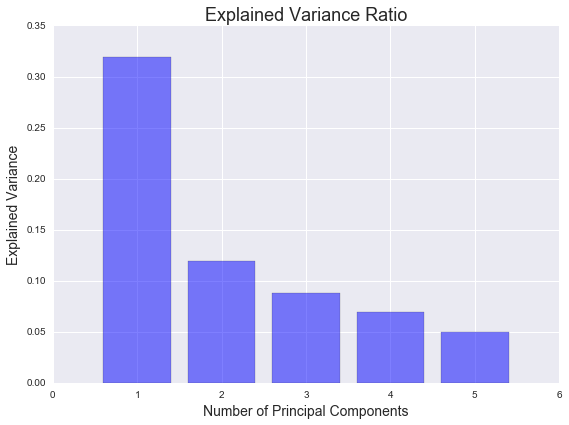

In [97]:
def doPCA():
    pca = PCA(n_components=5)
    pca.fit(df_scale)
    return pca

def plot_explained_variance(ex_var):
    pl.figure(figsize=(8,6))
    pl.bar(range(1,6), ex_var, alpha=0.5, align='center', color = 'b')
    pl.xlabel('Number of Principal Components', fontsize = 14)
    pl.ylabel('Explained Variance', fontsize =14)
    pl.title('Explained Variance Ratio', fontsize = 18)
    pl.tight_layout()
    pl.show

#Standardize features by removing the mean and scaling to unit variance
columns = X_all.columns
scale = preprocessing.scale(X_all)
df_scale = pd.DataFrame(scale, columns=columns)
#df_scale.head()

# Print the components and the amount of variance in the data contained in each dimension
pca = doPCA()
columns = X_all.columns
df_pca = pd.DataFrame(pca.components_, columns = columns)
df_pca.index.names = ['PC']
print "Principal Component Analysis:"
print df_pca.head()

ex_var = pca.explained_variance_ratio_
df_var = pd.Series(ex_var)
df_var.sort(ascending=False)

df_var.index.names = ['PC']
print "\nExplained Variance of Each Component:"
print df_var.head()

plot_explained_variance(ex_var)

### Dimensionality Reduction

In [98]:
X_scale = df_scale
from sklearn import decomposition

def run_RF_PCA(number_runs):
    for num in range(0, number_runs):
        start = time.time()
        X_train, X_test, y_train, y_test = Stratified_Shuffle_Split(X_scale, y_all, num_test)

        # Dimension Reduction
        pca = decomposition.RandomizedPCA(n_components=20, whiten=True)
        fit = pca.fit(X_train)
        X_train_pca = pca.transform(X_train)
        X_test_pca = pca.transform(X_test)

        clf = RandomForestClassifier(n_estimators = 30)
        clf.fit(X_train_pca, y_train)
        
        pred = clf.predict(X_test_pca)
        class_report = classification_report(y_test, pred) #report
        f1 = round(f1_score(y_test, pred, average='weighted'),3) #f1 score
        
        '''Confusion Matrix: Testing Set'''
        y_true, y_pred = y_test, pred
        cm_pca = confusion_matrix(y_true, y_pred)
        pl.figure()
        pca_plot_confusion_matrix(cm_pca, title='Confusion Matrix')

        print "Classification Report:"
        print class_report
        print "\nF1 Score: %s" % f1
        print "\nConfusion Matrix"
        print cm_pca
        
def pca_plot_confusion_matrix(cm_pca, title='Confusion Matrix: PCA'):
    names_x = ['Trump','Kasich','Cruz']
    names_y = ['Cruz','Kasich','Trump']
    sns.heatmap(cm_pca,annot=True, fmt='',cmap=pl.cm.Blues)
    pl.title(title, fontsize =20)
    tick_marks_x = np.arange(len(names_x))
    tick_marks_y = np.arange(len(names_y))
    pl.xticks(tick_marks_x,names_x, rotation=45)
    pl.yticks(tick_marks_y,names_y)
    pl.tight_layout()
    pl.ylabel('True label', fontsize =14)
    pl.xlabel('Predicted label', fontsize =14)

Classification Report:
             precision    recall  f1-score   support

Donald_Trump       0.81      0.92      0.86       177
John_Kasich       1.00      0.10      0.18        10
   Ted_Cruz       0.78      0.65      0.70        96

avg / total       0.80      0.80      0.78       283


F1 Score: 0.783

Confusion Matrix
[[163   0  14]
 [  5   1   4]
 [ 34   0  62]]


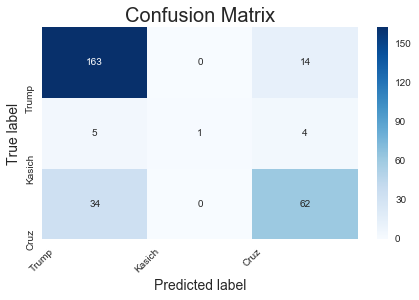

In [99]:
run_RF_PCA(1)

- It should also be mentioned that reducing the high dimensional space using PCA was explored.  As in the case of this dataset, in the presence of a large number of attributes, it may be useful to reduce the dimensions with an unsupervised learning method such as PCA prior to the supervised steps.  The idea here is to determine whether or not the performance of the Random Forest learning algorithm improves by applying dimensionality reduction. The first step is to standardize features by removing the mean and scaling to unit variance since the data is comprised of various units. The eigenvectors of the covariance matrix represents the principal components (directions of maximum variance and determined the direction of the new feature space) and the eigenvalues (scalar) correspond to the magnitude of the eigenvectors. This means that the eigenvalues explains the variance along the new feature axes. From the table above, it can be observed that PST040210 and POP010210 have the high magnitudes and seem to be more influential. The first two principal components only account for 45% of the total variance and the first 5 accounting for nearly 65%. The training data features were projected onto the top several principal components and then the transformed dimensional space (n_components = 4) was passed to the Random Forest classifier. The resultant F1 virtually remained the same as the fine-tuned RF model with a score of 0.78.

### Conclusion

- The goal of this project is to initially provide correlations among Democratic/Republican candidates with respect to a large number of demographic features. As pointed out in the analysis, we can observe trends in the data such as Senator Sanders performing better among college students where there is high population of whites. Or other trends such as Trump performing better in areas with a higher percentage of African Americans with median household incomes ranging between $30-60K than Senator Cruz. This analysis is intended to provide the viewer with an understanding of the dataset at hand, such as trends in the demographics as a whole and how candidates could expect to perform with similar characteristics in other future primary counties. We can also observe which statistics yielded the highest magnitude of votes, which could be key indicators as to which features are highly influential for that candidate’s success. From there, the goal is to generate a predictive model that learns from previous data (training set) and generalizes to the future out of sample data that yields the lowest classification error as possible. Before using the model presented in this work in a general setting in which campaign leaders of the respected candidates could draw predictions from in regards to adjusting their strategies for the remaining 2016 race to the White House, I would like to see the performance of the classifier increase; this could entail implementing another classification algorithm other than the ones described in this analysis. Additionally, adding more features such as the percentage of males, various age groups, or unemployment rate just to name a few, could shed more insights into how a given region, state, or county would tend to elect as the next party nominee and ultimately the next President of the United States.   


### ** Updated April 26, 2016 **

- Results from several additional primary states are in the books. Donald Trump picked up clean sweep of a series of the following Northeastern states: Maryland, Pennsylvania, Delaware, Rhode Island, and Connecticut. With a significant margin of votes/counties picked up by Trump, we can include this additional data and how the model performs. From the current model, would you have thought such wins by Trump were expected based on the demographics of these primary states? Interesting questions!
